# Definitions



*   Ways to make it more efficient, using lines or diagonals
*   MaxPool layers with -maxpool(-x)



In [ ]:
!nvidia-smi

Sun Feb 25 00:18:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!export CUDA_LAUNCH_BLOCKING=1

In [ ]:
!pip install dtw-python

In [ ]:
import pdb

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
# baseline dtw functions
def compute_euclidean_distance_matrix(x, y) -> np.array:
    """Calculate distance matrix
    This method calcualtes the pairwise Euclidean distance between two sequences.
    The sequences can have different lengths.
    """

    if len(x) < len(y):
        x, y = y, x

    dist = np.zeros((len(x), len(y)))

    for i in range(len(x)):
        for j in range(len(y)):
            dist[i,j] = (x[i]-y[j])**2
    return dist

def compute_total_cost(cost_mat):
  up_cost_mat = cost_mat
  running_cost = cost_mat[0,0]
  x = 0
  y = 0

  cost_mat = np.pad(cost_mat, ((0,1), (0,1)), mode='constant', constant_values=np.inf)

  while True:
    if x == up_cost_mat.shape[1]-1 and y == up_cost_mat.shape[0]-1:
      break

    win = cost_mat[y:y+2, x:x+2].flatten()[1:]

    min_val = np.min(win[::-1])
    min_index = (2-np.argmin(win[::-1])) + 1

    x_adj = min_index % 2
    y_adj = min_index // 2

    running_cost += min_val

    x += x_adj
    y += y_adj

  return running_cost

def compute_accumulated_cost_matrix(x, y) -> np.array:
    """Compute accumulated cost matrix for warp path using Euclidean distance
    """
    distances = compute_euclidean_distance_matrix(x, y)

    # print(distances)

    # Initialization
    cost = np.zeros((len(y), len(x)))
    cost[0,0] = distances[0,0]

    # print(cost)

    for i in range(1, len(y)):
        cost[i, 0] = distances[i, 0] + cost[i-1, 0]

    for j in range(1, len(x)):
        cost[0, j] = distances[0, j] + cost[0, j-1]

    # print(cost)

    # Accumulated warp path cost
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            cost[i, j] = min(
                cost[i-1, j],    # insertion
                cost[i, j-1],    # deletion
                cost[i-1, j-1]   # match
            ) + distances[i, j]

    return cost

def baseline_dtw(x, patterns):
    costs = np.zeros(patterns.shape[0])

    for i in range(patterns.shape[0]):
      cost_mat = compute_accumulated_cost_matrix(x, patterns[i])
      total_cost = compute_total_cost(cost_mat)
      costs[i] = total_cost

    return costs

What if there are multiple elements with the same cost?

Improvement: the order of the two sequences can be swapped to put the shorter one first (x len) and dtw will still give the same result.

Can further optimization also be performed for non-symmetric sequences? To minimizes the number of masks needed?

In [ ]:
def gen_mask_seq(row, col):
  masks = []

  i=0
  j=0

  for line in range(1, (row + col)):
    start_col = max(0, line - row)
    count = min(min(line, (col - start_col)), row)

    mask = np.zeros((row, col))

    for i in range(count):
      mask[min(row, line) - i - 1][start_col + i] = 1

    masks.append(mask)

  return np.array(masks)

def gen_start_indices(num_patterns, rows_per_pattern):
  rpr = rows_per_pattern

  x_base = torch.Tensor([[0,1,0,1]]).repeat(num_patterns, 1).type(torch.int32)

  y_base = []

  for i in range(num_patterns):
    entry = [rpr*i, rpr*i, rpr*i+1, rpr*i+1]
    y_base.append(entry)

  y_base = torch.Tensor(y_base).type(torch.int32)

  return x_base, y_base

*   Add functionality to calculate the lowest cost from the cost matrix
*   Add support for batching
*   Add JIT for further optimization
*   Disable gradients for DTW for all tensors
*   Priority for operations is (diagonal, down, right)

In [ ]:
class DTW(nn.Module):
    def __init__(self, kernel_size = 2, device='cpu'):
      super(DTW, self).__init__()
      self.kernel_size = kernel_size
      self.pool1 = nn.MaxPool2d(kernel_size=kernel_size, stride=1, padding=0)
      self.device = device

    def min_pool(self, x):
        x_fmt = x.unsqueeze(0)
        res = -self.pool1(-x_fmt)
        return res.view(x.shape[0], x.shape[1]-1, x.shape[2]-1)

    def forward(self, x, y):
      cost_mats = self.__calc_cost_mats(x, y)
      acc_costs = self.__acc_costs(cost_mats)

      return acc_costs

    def __acc_costs(self, cost_mats):
      pad_cost_mats = F.pad(cost_mats, (0, 1, 0, 1, 0, 0), 'constant', torch.inf)
      cmr = pad_cost_mats.reshape(-1, pad_cost_mats.shape[2])

      start_indices = gen_start_indices(pad_cost_mats.shape[0], pad_cost_mats.shape[1])

      max_iter = cost_mats.shape[1] + cost_mats.shape[2] - 1
      cost_vec = cost_mats[:, 0, 0]

      x_indices = start_indices[0].to(self.device)
      y_indices = start_indices[1].to(self.device)

      for i in range(max_iter):
          sel = cmr[y_indices, x_indices]
          sel[:, 0] = torch.inf

          # enforce priority of operations: diagonal, down, right (for edge case when multiple adjacent entries have the same value)
          sel_rev = torch.flip(sel, dims=[1])
          values, indices = torch.min(sel_rev, dim=1)
          last_indices = 3 - indices
          ind_mod_loc = torch.where(values==torch.inf)[0]
          last_indices[ind_mod_loc] = 0

          values[values==torch.inf] = 0

          x_adj = last_indices.reshape(-1, 1).repeat(1, 4) % 2
          y_adj = last_indices.reshape(-1, 1).repeat(1, 4) // 2
          x_indices = x_indices + x_adj
          y_indices = y_indices + y_adj

          cost_vec += values

      return cost_vec

    def __calc_cost_mats(self, x, y):
        # input x should be a single sequence
        # input y can be a 2D tensor, a list of sequences
        x_len = x.shape[-1]
        y_len = y.shape[-1]

        n_patterns = y.shape[0]

        # swap to put the longer sequence on the x-axis of the matrix
        if (y_len < x_len):
          y_shorter = True
          mask_dim1, mask_dim2 = y_len, x_len
        else:
          y_shorter = False
          mask_dim1, mask_dim2 = x_len, y_len

        masks = gen_mask_seq(mask_dim1, mask_dim2)
        masks = torch.Tensor(masks).to(self.device)

        inf_masks = masks.clone()
        inf_masks[inf_masks==1] = torch.inf
        inf_masks = F.pad(inf_masks, (1,0,1,0), 'constant', 0)

        # x is mapped along x-axis of cost matrix
        x_mat_ = torch.repeat_interleave(x, y_len, dim=0)
        x_mat = torch.repeat_interleave(x_mat_.unsqueeze(0), n_patterns, dim=0)

        if not y_shorter:
          x_mat = x_mat.permute(0, 2, 1)

        # print(x_mat)

        # y is mapped along y-axis of cost matrix (starting in upper-left corner)
        y_mat = torch.repeat_interleave(y.unsqueeze(1), x_len, dim=1)

        if y_shorter:
          y_mat = y_mat.permute(0, 2, 1)

        # fill in the cost matrix
        cost_mat_ = (x_mat - y_mat)**2

        cost_mat = F.pad(cost_mat_, (1,0,1,0,0,0), 'constant', 0)

        # pad with inf
        cost_mat[:, 0, 1:] = torch.inf
        cost_mat[:, 1:, 0] = torch.inf

        inner_cost_mat = cost_mat[:, 1:, 1:]

        for i in range(masks.shape[0]):
            mask_mat_ = masks[i]
            mask_mat = torch.repeat_interleave(mask_mat_.unsqueeze(0), n_patterns, dim=0)

            inf_mask_mat_ = inf_masks[i]
            inf_mask_mat = torch.repeat_interleave(inf_mask_mat_.unsqueeze(0), n_patterns, dim=0)

            inf_mask_cost_mat = cost_mat + inf_mask_mat

            pooled_res = self.min_pool(inf_mask_cost_mat)

            inner_cost_mat += (mask_mat * pooled_res)

        return inner_cost_mat

In [ ]:
import time

def time_execution(f, args):
  start_time = time.time()

  val = f(*args)

  end_time = time.time()
  elapsed_time = (end_time - start_time) * 1000

  return elapsed_time, val

# Test DTW Module

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
dtw = DTW(device=device).to(device)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
n_patterns = [1, 10, 100, 200, 500, 1000, 5000, 10000]

b_times = np.zeros(len(n_patterns))
g_times = np.zeros(len(n_patterns))

for i, n in tqdm(enumerate(n_patterns)):
  key = np.random.rand(50)
  patterns = np.random.rand(n,50)

  b_time, b_results = time_execution(baseline_dtw, (key, patterns))

  key_tensor = torch.Tensor(key).to(device).reshape(1, -1)
  patterns_tensor = torch.Tensor(patterns).to(device)

  g_time, g_results = time_execution(dtw, (key_tensor, patterns_tensor))

  b_times[i] = b_time
  g_times[i] = g_time

0it [00:00, ?it/s]

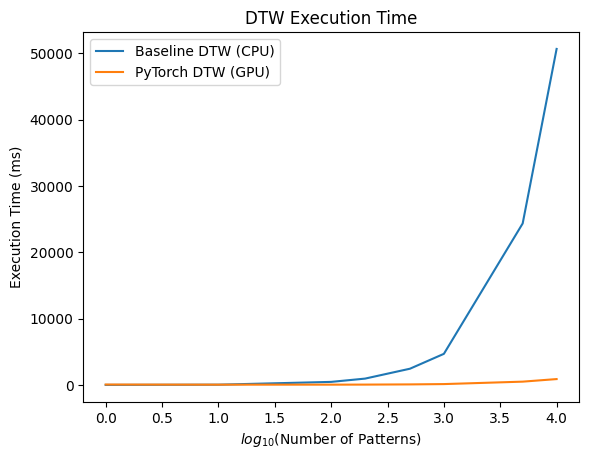

In [ ]:
plt.figure()

log_n_patterns = np.log10(n_patterns)

plt.plot(log_n_patterns, b_times, label='Baseline DTW (CPU)')
plt.plot(log_n_patterns, g_times, label='PyTorch DTW (GPU)')

plt.xlabel('$log_{10}$(Number of Patterns)')
plt.ylabel('Execution Time (ms)')

plt.title('DTW Execution Time')

plt.legend()

In [ ]:
import pandas as pd

In [ ]:
timing_data = pd.DataFrame({'Number of Patterns': n_patterns, 'Baseline DTW (CPU)': b_times, 'Pytorch DTW (GPU)': g_times})

In [ ]:
timing_data

,Number of Patterns,Baseline DTW (CPU),Pytorch DTW (GPU)
0,1,11.034012,70.121288
1,10,46.255112,51.036119
2,100,468.550444,51.838875
3,200,963.412046,59.313297
4,500,2454.096556,89.866400
5,1000,4697.286367,137.516737
6,5000,24353.886843,504.556417
7,10000,50667.236567,892.032623
